<a href="https://colab.research.google.com/github/NajlaaNawaii/Karpathy-s-Neural-Networks-/blob/main/Micrograd/Building_Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Derivatives
- When I differentiate a function with respect to a particular variable, I'm determining how much the function's value changes when I slightly adjust that specific variable.

#Visualization code to draw the computational graph

In [1]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f |grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


#Value Class
The `Value` class in a neural network tracks the results of calculations during the forward pass and stores how those results were obtained. It also maintains the computational graph, which is essential for backpropagation. Each instance of the `Value` class represents weights, biases, or intermediate results and defines how gradients are calculated and propagated during training. This enables the automatic differentiation needed for optimizing the network.

In [5]:
class Value:

  def __init__(self,data,_children=(),_op="",label=""):
    self.data=data
    self._prev=set(_children)
    # Stores the function to calculate the gradient during backpropagation
    self._backward=lambda:None
    self.grad=0
    self._op=_op
    self.label=label

  # Returns a string representation of the Value object
  def __repr__(self):
    return f"Value(data={self.data})"

  # Defines how two Value objects (or a Value and a number) are added together
  def __add__(self,other):
    # Ensure the "other "" is a Value object
    other = other  if isinstance(other,Value) else Value(other)
    output=Value(self.data + other.data, (self,other),"+")
    def _backward():
      #adding the contrbution of upper stream gradients, preventing overwriting
      self.grad += 1.0 * output.grad
      other.grad += 1.0 * output.grad
    output._backward= _backward
    return output

  # Defines subtraction as negating the other operand and adding
  def __neg__(self):
    return self*-1

  def __sub__(self,other):
    return self + other.__neg__()


  # Defines how two Value objects (or a Value and a number) are multiplied
  def __mul__(self,other):
    # Ensure the "other" operand is a Value object
    other= other  if isinstance(other,Value) else Value(other)
    output=Value(self.data * other.data, (self,other),"*")
    def _backward():
      self.grad += other.data * output.grad
      other.grad += self.data * output.grad

    output._backward=_backward
    return output

  # Handles multiplication when the Value object is on the right side of the operator
  def __rmul__(self, other):
        return self * other


  # Defines true division (e.g., a / b) as multiplication by the reciprocal
  def __truediv__(self, other):
      return self * other ** -1


  # Defines how a Value object is raised to a power
  def __pow__(self,other):
    assert isinstance(other,(int,float))
    output=Value(self.data**other, (self,),"**")
    def _backward():
      self.grad += other * (self.data**(other-1)) * output.grad
    output._backward=_backward
    return output

  # Defines the exponential function and its gradient
  def exp(self):
      output = Value(np.exp(self.data), (self,), "exp")
      def _backward():
          # Accumulates the gradient considering the derivative of exp
          self.grad += output.data * output.grad
      output._backward = _backward
      return output



  # Defines the tanh activation function and its gradient
  def tanh(self):
    x=self.data
    tanh_output=(np.exp(2*x)-1)/(np.exp(2*x)+1)
    output=Value(tanh_output, (self,),"tanh")
    def _backward():
      self.grad += (1-tanh_output**2) * output.grad
    output._backward=_backward
    return output


  #Building the topological order of the computational graph
  def backward(self):
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        # Adds node to the list only after all its dependencies are processed
        topo.append(v)


    build_topo(self)

    #Base case: Initialize the gradient at the output (starting point)
    self.grad=1.0
    # Apply the chain rule to propagate the gradients backward
    for node in reversed(topo):
      node._backward()


In [11]:
import random,numpy as np

In [8]:
#Inputs
x1=Value(2.0,label="x1")
x2=Value(0.0,label="x2")

#weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")

#bias
b=Value(6.8813735870195432,label="b")


#input_layer
x1w1=x1*w1; x1w1.label="x1w1"
x2w2=x2*w2; x2w2.label="x2w2"

# output
summed=x1w1+x2w2; summed.label="summed"
biased_sum=summed + b; biased_sum.label="biased_sum"

#activated_output
# activated_output= biased_sum.tanh(); activated_output.label="activated_output"

#replacing tanh with its components functions
exp_output= (2*biased_sum).exp(); exp_output.label="exp_output" #that's why we need rmul
activated_output=(exp_output-1) / (exp_output+1) ; activated_output.label="activated_output"

In [9]:
activated_output.backward()

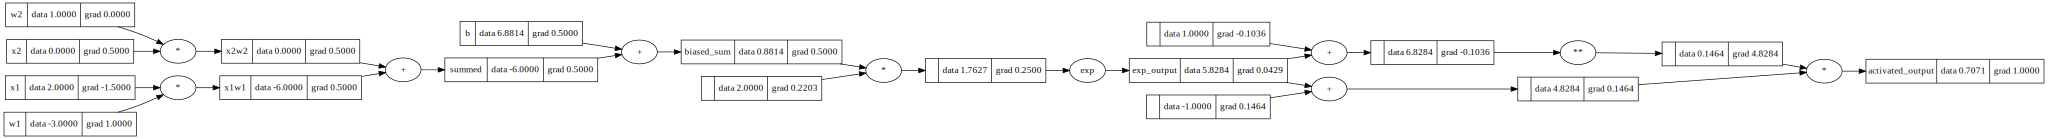

In [10]:
draw_dot(activated_output)

#Neural Network

In [12]:
class Neuron:
  def __init__(self,nin):
    # Randomly initialize the weights and bias for this neuron
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))



  def __call__(self,x):
    '''
    - Operations with non_Value_Class x handled by definition in _mul_ & _add_
    - Generator expression computes each weight * input pair on-the-fly
    '''
    #Sum starts with b
    acttivation=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    output=acttivation.tanh()
    return output

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.Neurons=[Neuron(nin) for _ in range(nout)]



  def __call__(self,x):
    outputs=[n(x) for n in self.Neurons]
    #List of outputs, element for each neuron
    return outputs[0] if len(outputs)==1 else outputs

  def parameters(self):
    return [p for neuron in self.Neurons for p in neuron.parameters()]


class MLP:
  def __init__(self,nin,nouts):
    #Concatenate the nin to the beginning of nouts list
    sizes=[nin]+nouts
    self.Layers=[ Layer(sizes[i],sizes[i+1]) for i in range(len(nouts)) ]

  def __call__(self,x):
    # Feed the input through each layer in sequence
    for layer in self.Layers:
      x= layer(x)
    return x

  def parameters(self):
    return [p for layer in self.Layers for p in layer.parameters()]




In [13]:
xs=[[2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]]

ys=[1.0,-1.0,-1.0,1.0]
N=MLP(3,[4,4,1])


#Gradient Descent

In [15]:
for step in range(100):
  #Forward pass
  ypred=[N(x) for x in xs]

  #Loss Calculation
  loss=sum(((y_hat - y_true)**2 for y_hat,y_true in zip(ypred,ys)),Value(0.0))


  # Reset all gradients to zero before backpropagation
  for p in N.parameters():
    p.grad=0.0

  # Backward pass: Compute the gradients of the loss with respect to all parameters
  loss.backward()

  # Update the parameters
  for p in N.parameters():
    p.data+=-.05*p.grad


  print(step,loss.data)




0 0.015077454965343396
1 0.014738855365610674
2 0.014414804433208804
3 0.014104393632840335
4 0.013806788075755515
5 0.013521219236647907
6 0.013246978515436646
7 0.012983411532027915
8 0.012729913058741054
9 0.012485922508965457
10 0.01225091991226371
11 0.012024422315947511
12 0.01180598056144205
13 0.011595176390777069
14 0.011391619844513024
15 0.01119494691749865
16 0.01100481744320428
17 0.010820913181101944
18 0.010642936084765655
19 0.010470606731121011
20 0.0103036628936563
21 0.010141858244465733
22 0.009984961171783584
23 0.009832753701220182
24 0.009685030510265478
25 0.009541598026805
26 0.009402273603427071
27 0.009266884760206038
28 0.009135268489439142
29 0.009007270616515458
30 0.008882745211710988
31 0.008761554048246531
32 0.008643566102427811
33 0.008528657092110828
34 0.008416709050115037
35 0.008307609929541306
36 0.00820125323825024
37 0.008097537700023652
38 0.007996366940167145
39 0.00789764919352686
40 0.007801297033080204
41 0.007707227117433171
42 0.00761535

#What I learned ( While training Neural Nets )
1. Better understanding of OOP.
2. Defining operations for class instances with special functions.
3. List comprehensions.
4.  Generators.

